In [2]:
from pathlib import Path
from cv2 import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
import matplotlib.pyplot as plt
import scipy.io
import numpy
from sklearn import decomposition
from sklearn import discriminant_analysis
import re
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from pathlib import Path
import os
import matplotlib.pyplot as plt
import random
from tensorflow.python.client import device_lib 

import sys
import numpy as np
from datetime import datetime

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))


Num GPUs: 1


In [5]:
def readImage(path, name):
    folder = Path(path).rglob('*.jpg')
    files = [x for x in folder]
    ImageArray = []
    yarray = []
    for x in files:
        img = cv2.imread(str(x))
        # img = img.flatten('C')
        ImageArray.append(img)
        test = re.search("[0-9]{4}", str(x))
        yarray.append(int(test[0]))
    obj_arr = numpy.zeros((2,), dtype=numpy.object)
    obj_arr[0] = ImageArray
    obj_arr[1] = numpy.transpose([yarray])
    scipy.io.savemat('./Data/Q2/matfiles' + name + '.mat',
                     mdict={'x': obj_arr[0], 'y': obj_arr[1]})


def createFig(imgArray):
    # print(imgArray)
    fig = plt.figure(figsize=(50, 50))
    for i in range(10):
        ax = fig.add_subplot(50, 50, i+1)
        ax.imshow(imgArray[i, :, :, :])
        # ax.imshow(imgArray[:,:,:,i])

def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = plot_confusion_matrix(model, X_train, Y_train, normalize='true', ax=ax)
    conf.ax_.set_title('Training Set Performance');
    ax = fig.add_subplot(1, 2, 2)
    conf = plot_confusion_matrix(model, X_test, Y_test, normalize='true', ax=ax)
    conf.ax_.set_title('Test Set Performance');
    pred = model.predict(X_test)
    print('Test Accuracy: ' + str(sum(pred == Y_test)/len(Y_test)))


In [6]:
"""
readImage('./Data/Q2/Testing/Gallery', 'Gallery')
readImage('./Data/Q2/Testing/Probe', 'Probe')
readImage('./Data/Q2/training', 'Training')

"""
Training = scipy.io.loadmat('./Data/Q2/matfilesTraining.mat')
Probe = scipy.io.loadmat('./Data/Q2/matfilesProbe.mat')
Gallery = scipy.io.loadmat('./Data/Q2/matfilesGallery.mat')


In [7]:
training_x_Org = Training['x'].astype("float32") / 255.0
training_x = training_x_Org
training_y_Org = Training['y']
training_y = training_y_Org
testing_Probe_x_Org = Probe['x'].astype("float32") / 255.0
testing_Probe_x = testing_Probe_x_Org
print(testing_Probe_x.shape)
testing_Probe_y_Org = Probe['y']
testing_Probe_y = testing_Probe_y_Org
print(testing_Probe_y.shape)
testing_Gallery_x_Org = Gallery['x'].astype("float32") / 255.0
testing_Gallery_x = testing_Gallery_x_Org
print(testing_Gallery_x.shape)
testing_Gallery_y_Org = Gallery['y']
testing_Gallery_y = testing_Gallery_y_Org
print(testing_Gallery_y.shape)

(301, 128, 64, 3)
(301, 1)
(301, 128, 64, 3)
(301, 1)


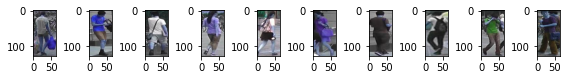

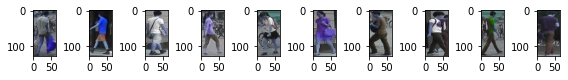

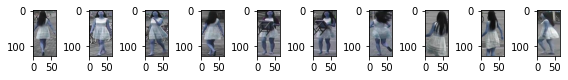

In [8]:
createFig(testing_Gallery_x)
createFig(testing_Probe_x)
createFig(training_x)


In [9]:
# Flatten Arrays

Flatten_trainx = training_x.flatten().reshape(5933, 24576)
Flatten_testingGalleryx = testing_Gallery_x.flatten().reshape(301, 24576)
print("Done")


Done


In [10]:
"""
pca = decomposition.PCA()
pca.fit(Flatten_trainx)
transformed = pca.transform(Flatten_trainx)
transformed_test = pca.transform(Flatten_testingGalleryx)

cumulative_sum = numpy.cumsum(pca.explained_variance_ratio_, axis=0)
top95 = numpy.where(cumulative_sum > 0.95)[0][0]

fig = plt.figure(figsize=[20, 5])
count = 0
for i in range(5):
    for j in range(2):
        ax = fig.add_subplot(2, 10, count*2 + 1)
        ax.imshow(numpy.reshape(
            Flatten_trainx[count, :] - pca.mean_, (128, 64, 3)))
        ax.set_title('Original')
        ax = fig.add_subplot(2, 10, count*2 + 2)
        pca.mean_
        ax.imshow(numpy.reshape(pca.components_[0:top95, :].transpose().dot(
            numpy.reshape(transformed[count, 0:top95], (-1, 1))), (128, 64, 3)))
        ax.set_title('95% Reconstruction')
        count += 1
"""

"\npca = decomposition.PCA()\npca.fit(Flatten_trainx)\ntransformed = pca.transform(Flatten_trainx)\ntransformed_test = pca.transform(Flatten_testingGalleryx)\n\ncumulative_sum = numpy.cumsum(pca.explained_variance_ratio_, axis=0)\ntop95 = numpy.where(cumulative_sum > 0.95)[0][0]\n\nfig = plt.figure(figsize=[20, 5])\ncount = 0\nfor i in range(5):\n    for j in range(2):\n        ax = fig.add_subplot(2, 10, count*2 + 1)\n        ax.imshow(numpy.reshape(\n            Flatten_trainx[count, :] - pca.mean_, (128, 64, 3)))\n        ax.set_title('Original')\n        ax = fig.add_subplot(2, 10, count*2 + 2)\n        pca.mean_\n        ax.imshow(numpy.reshape(pca.components_[0:top95, :].transpose().dot(\n            numpy.reshape(transformed[count, 0:top95], (-1, 1))), (128, 64, 3)))\n        ax.set_title('95% Reconstruction')\n        count += 1\n"

In [11]:
"""
training_y = training_y.flatten()
testing_Gallery_y = testing_Gallery_y.flatten()
transformed_train_95 = transformed[:, 0:top95]
transformed_test_95 = transformed_test[:, 0:top95]

print(training_x.shape)
print(testing_Gallery_y.shape)
print(transformed_train_95.shape)
print(transformed_test_95.shape)
"""

'\ntraining_y = training_y.flatten()\ntesting_Gallery_y = testing_Gallery_y.flatten()\ntransformed_train_95 = transformed[:, 0:top95]\ntransformed_test_95 = transformed_test[:, 0:top95]\n\nprint(training_x.shape)\nprint(testing_Gallery_y.shape)\nprint(transformed_train_95.shape)\nprint(transformed_test_95.shape)\n'

In [12]:
"""
cknn_95 = KNeighborsClassifier(n_neighbors=3, weights='distance')
cknn_95.fit(transformed_train_95, training_y)
#eval_model(cknn_95, transformed_train_95, training_y, transformed_test_95, testing_Gallery_y)
"""

"\ncknn_95 = KNeighborsClassifier(n_neighbors=3, weights='distance')\ncknn_95.fit(transformed_train_95, training_y)\n#eval_model(cknn_95, transformed_train_95, training_y, transformed_test_95, testing_Gallery_y)\n"

In [13]:
def GetSiameseData(imgs, labels, batch_size):
    image_a = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    label = numpy.zeros(batch_size);
    for i in range(batch_size):
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)
        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l
    return [image_a, image_b], label

def PairGenerator(imgs, labels, batch_size):
    while True:
        [image_a, image_b], label = GetSiameseData(imgs, labels, batch_size)
        yield [image_a, image_b], label

def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    x = layers.Flatten()(x)
    for i in fc:
        x = fc_block(x, i, dropout)
    return x


In [14]:
deepLearning_x_train = training_x_Org.reshape(training_x_Org.shape[0], 128, 64, 3)
deepLearning_y_train = training_y_Org.reshape(training_y_Org.shape[0], 1)
deepLearning_x_test = testing_Gallery_x_Org.reshape(testing_Gallery_x_Org.shape[0], 128, 64, 3)
deepLearning_y_test = testing_Gallery_y_Org.reshape(testing_Gallery_y_Org.shape[0], 1)

[1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]


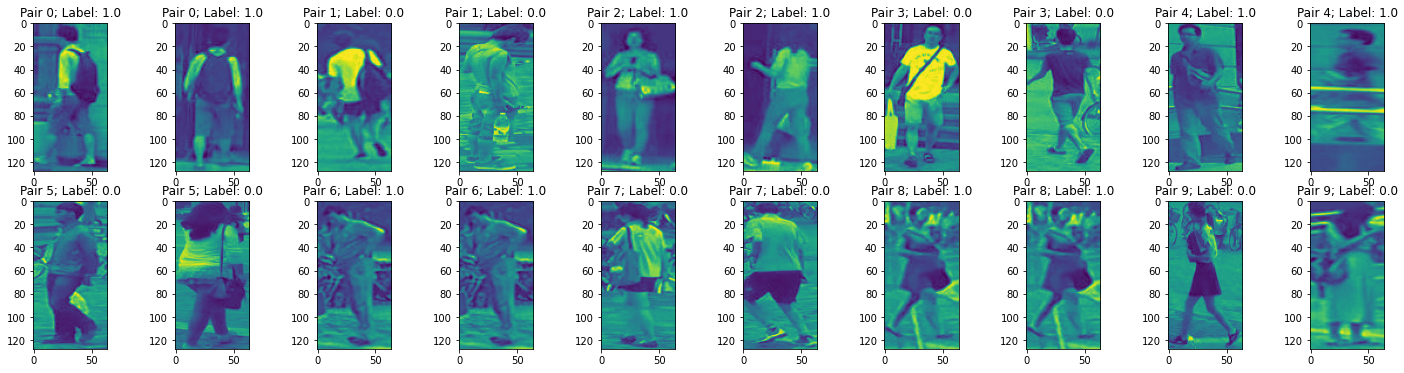

In [15]:
test = PairGenerator(deepLearning_x_train, deepLearning_y_train, 20)
x, y = next(test)
print(y)
fig = plt.figure(figsize=[25, 6])
for i in range(10):
    ax = fig.add_subplot(2, 10, i*2 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))
    ax = fig.add_subplot(2, 10, i*2 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i])) 


In [16]:
embedding_size = 32
dummy_input = keras.Input((128, 64, 3))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
base_network = keras.Model(dummy_input, embedding_layer, name='SiameseBranch')
base_network.summary()


Model: "SiameseBranch"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 64, 3)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 64, 8)        224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 64, 8)        584       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 64, 8)        32        
_________________________________________________________________
activation (Activation)      (None, 128, 64, 8)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 128, 64, 8)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 32, 8)       

In [17]:
input_a = keras.Input((128, 64, 3), name='InputA')
input_b = keras.Input((128, 64, 3), name='InputB')

embedding_a = base_network(input_a)
embedding_b = base_network(input_b)

In [18]:
combined = layers.concatenate([embedding_a, embedding_b])
combined = layers.Dense(128, activation='relu')(combined)
output = layers.Dense(1, activation='sigmoid')(combined)
siamese_network = keras.Model([input_a, input_b], output, name='SiameseNetwork')
siamese_network.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputA (InputLayer)             [(None, 128, 64, 3)] 0                                            
__________________________________________________________________________________________________
InputB (InputLayer)             [(None, 128, 64, 3)] 0                                            
__________________________________________________________________________________________________
SiameseBranch (Functional)      (None, 32)           4222216     InputA[0][0]                     
                                                                 InputB[0][0]                     
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 64)           0           SiameseBranch[0][0] 

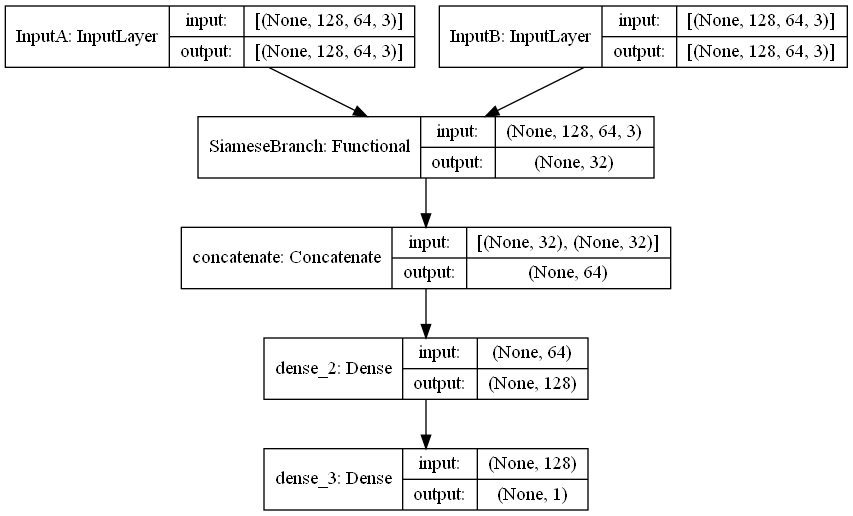

In [19]:
keras.utils.plot_model(siamese_network, show_shapes=True)

In [20]:
siamese_network.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])

In [21]:
batch_size = 64
training_gen = PairGenerator(deepLearning_x_train, deepLearning_y_train, batch_size)
siamese_test_x, siamese_test_y = GetSiameseData(deepLearning_x_test, deepLearning_y_test, 10000)
siamese_network.fit(training_gen, steps_per_epoch = 30000 // batch_size, epochs=10, validation_data = (siamese_test_x, siamese_test_y))



Epoch 1/10
468/468 [==============================] - 68s 133ms/step - loss: 0.6093 - accuracy: 0.6480 - val_loss: 0.3461 - val_accuracy: 0.8396
Epoch 2/10
468/468 [==============================] - 61s 130ms/step - loss: 0.3959 - accuracy: 0.8243 - val_loss: 0.2656 - val_accuracy: 0.8832
Epoch 3/10
468/468 [==============================] - 66s 140ms/step - loss: 0.3373 - accuracy: 0.8563 - val_loss: 0.2030 - val_accuracy: 0.9138
Epoch 4/10
468/468 [==============================] - 66s 142ms/step - loss: 0.2993 - accuracy: 0.8760 - val_loss: 0.1904 - val_accuracy: 0.9166
Epoch 5/10
468/468 [==============================] - 64s 136ms/step - loss: 0.2645 - accuracy: 0.8919 - val_loss: 0.1691 - val_accuracy: 0.9300
Epoch 6/10
468/468 [==============================] - 63s 134ms/step - loss: 0.2399 - accuracy: 0.9062 - val_loss: 0.1452 - val_accuracy: 0.9403
Epoch 7/10
468/468 [==============================] - 61s 131ms/step - loss: 0.2176 - accuracy: 0.9137 - val_loss: 0.1331 - val_ac

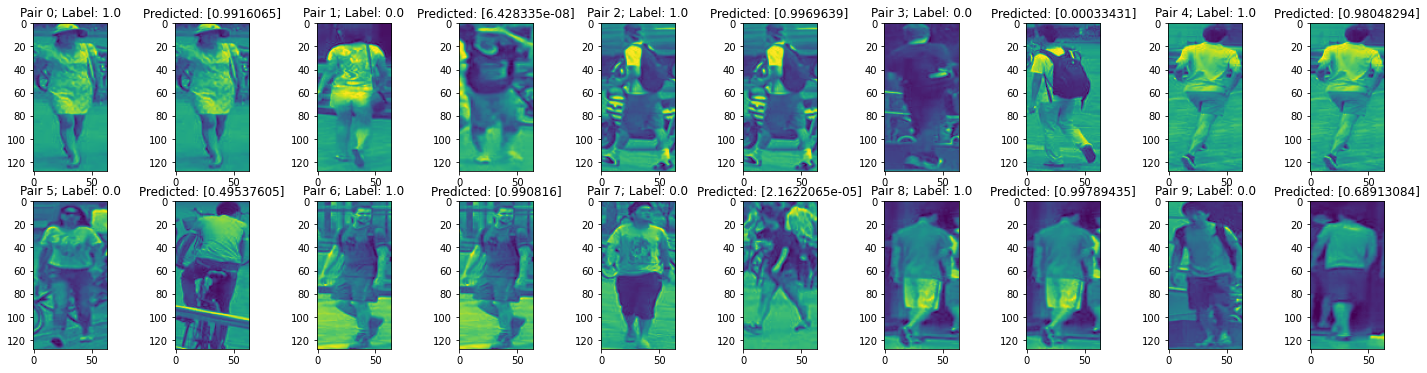

In [22]:
## Results
x, y = GetSiameseData(deepLearning_x_test, deepLearning_y_test, 10)
res = siamese_network.predict(x)

fig = plt.figure(figsize=[25, 6])
for i in range(10):
    ax = fig.add_subplot(2, 10, i*2 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))
    
    ax = fig.add_subplot(2, 10, i*2 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Predicted: ' + str(res[i]))

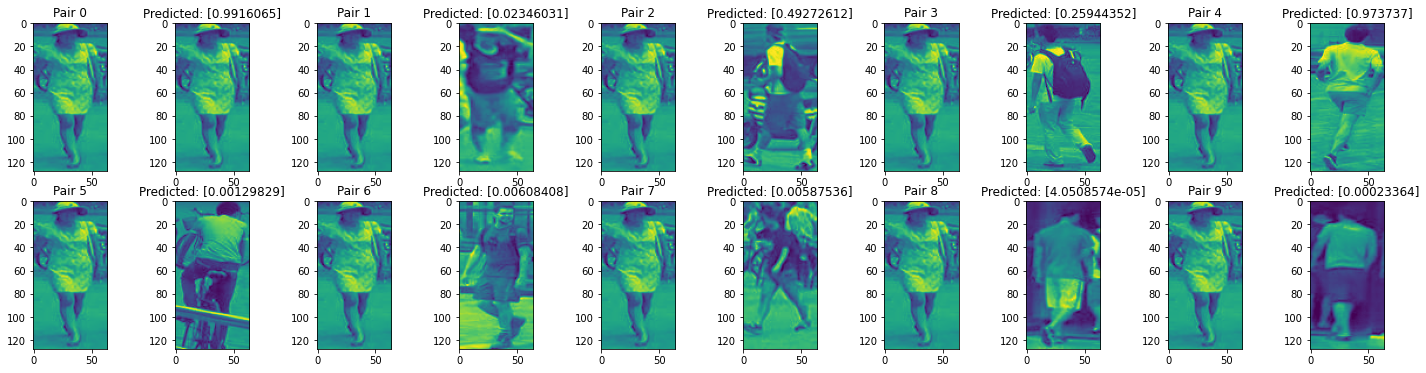

In [23]:
## Results
for i in range(10):
    x[0][i,:] = x[0][0,:]

res = siamese_network.predict(x)

fig = plt.figure(figsize=[25, 6])
for i in range(10):
    ax = fig.add_subplot(2, 10, i*2 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Pair ' + str(i))
    
    ax = fig.add_subplot(2, 10, i*2 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Predicted: ' + str(res[i]))

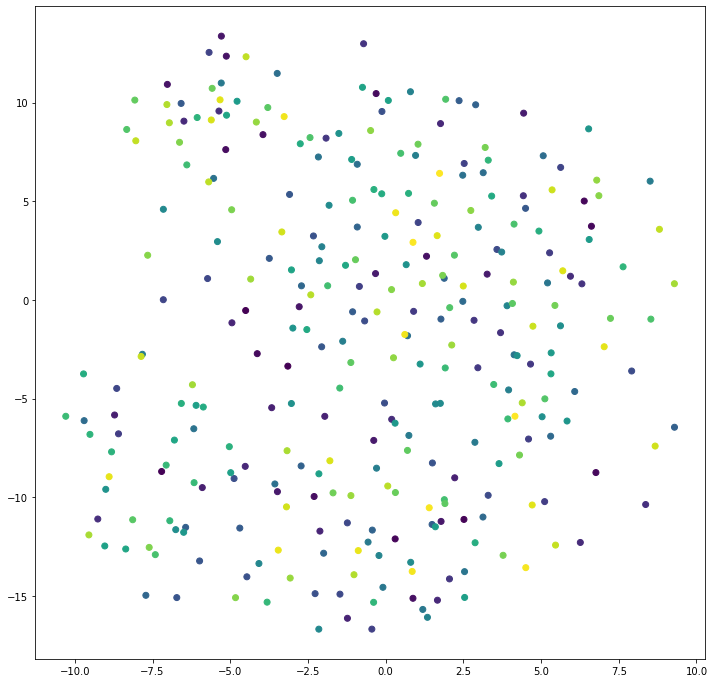

In [37]:
embeddings = base_network.predict(deepLearning_x_test)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = deepLearning_y_test.flatten());

In [24]:
"""
embedding_size = 32
dummy_input = keras.Input((128, 64, 3))
vgg_network = vgg_net(dummy_input, [16, 32, 64], [1024,512], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(vgg_network)
output_layer = layers.Dense(1, activation=None, name='feature_extractor')(embedding_layer)
vgg_network = keras.Model(dummy_input, output_layer, name='SimpleVGGNetwork')

vgg_network.summary()
"""


"\nembedding_size = 32\ndummy_input = keras.Input((128, 64, 3))\nvgg_network = vgg_net(dummy_input, [16, 32, 64], [1024,512], 0.2, 0)\nembedding_layer = layers.Dense(embedding_size, activation=None)(vgg_network)\noutput_layer = layers.Dense(1, activation=None, name='feature_extractor')(embedding_layer)\nvgg_network = keras.Model(dummy_input, output_layer, name='SimpleVGGNetwork')\n\nvgg_network.summary()\n"

In [25]:
"""
vgg_network.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
history = vgg_network.fit(deepLearning_x_train, deepLearning_y_train,
                        batch_size=64,
                        epochs=10,
                        validation_data=(deepLearning_x_test,deepLearning_y_test))
"""

"\nvgg_network.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),\n              optimizer=keras.optimizers.RMSprop(),\n              metrics=['accuracy'])\nhistory = vgg_network.fit(deepLearning_x_train, deepLearning_y_train,\n                        batch_size=64,\n                        epochs=10,\n                        validation_data=(deepLearning_x_test,deepLearning_y_test))\n"

In [26]:
"""
intermediate_layer_model = keras.Model(inputs=vgg_network.input,
                                       outputs=vgg_network.get_layer('feature_extractor').output)
embeddings = intermediate_layer_model(deepLearning_x_test)
embeddings.summary()

tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = deepLearning_y_test.flatten());
"""

"\nintermediate_layer_model = keras.Model(inputs=vgg_network.input,\n                                       outputs=vgg_network.get_layer('feature_extractor').output)\nembeddings = intermediate_layer_model(deepLearning_x_test)\nembeddings.summary()\n\ntsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)\nfig = plt.figure(figsize=[12, 12])\nax = fig.add_subplot(1, 1, 1)\nax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = deepLearning_y_test.flatten());\n"